# Detection of parked cars in the city of Granada.
## Image segmentation using deep learning techniques.
### Notebook 4: Segmentation Model using DeepLabV3+.

### Authors:
- **Luis Crespo Orti**
- **Isabel María Moreno Cuadrado**
- **Pablo Olivares Martínez**
- **Ximo Sanz Tornero**

# 1. Import libraries and functions

In [2]:
%pip install torch torchvision fastai segmentation-models-pytorch opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 805.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5f92197e8064558f3ef95facbc6a73419ad0dd6bd7ecd4167fdb4701d8218db9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8033c67ca3f1f46dd643b1fbd80cf212748e5a425139e677b60f43b23e46e717
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import csv

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we display the graphic card we are using and subsequently confirm the availability of the GPU. This step is taken to ensure that we do not default to using the CPU, as doing so would result in significantly higher time costs. We have previously installed the Torch library for NVIDIA GPUs on Linux, which includes CUDA acceleration, for the local executions we have conducted. Ultimately, however, the entire collaboration has been executed in google collab.

In [5]:
!nvidia-smi

Sun Jan 14 19:14:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

Tesla T4
True


### Function to Display Evaluation Metrics

This function, `plot_metrics`, developed by Ignacio Oguiza and detailed in his [forum post](https://forums.fast.ai/t/plotting-metrics-after-learning/69937), is an extension for the `Recorder` class in FastAI.

The function neatly organizes and displays the training metrics, leveraging the power of matplotlib for visualization. By stacking the values recorded during training and extracting the relevant metric names, it dynamically adjusts the number of rows and columns for the subplot based on the quantity of metrics to be displayed. This dynamic layout ensures that the visual representation is both clear and concise, regardless of the number of metrics.

Special attention is paid to aesthetics and clarity in the graph. Different colors are used to distinguish between training and validation metrics, enhancing the visual appeal and readability. The function also includes a check to hide any extra subplot axes, maintaining a neat presentation.

This utility is particularly useful for model evaluation in machine learning workflows, providing a quick and comprehensive view of performance metrics across both training and validation phases.


In [7]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off()
           for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i ==
                0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

### Function to Save Metrics to a CSV File

In our project, we have implemented a function `save_metrics_to_csv` that serves the crucial purpose of exporting training metrics to a CSV file. This functionality enhances data analysis and record-keeping capabilities for machine learning models.

The function takes a `learner` object from the FastAI library and a file path, defaulting to 'unet_metrics.csv', as inputs. By accessing the `recorder` attribute of the learner, it retrieves the stacked array of metric values and their corresponding names.

The core of the function lies in its ability to write these metrics into a CSV file. It begins by creating a file at the specified path and then proceeds to write the headers, which are the names of the metrics, followed by the metric values for each epoch. This process not only captures the numerical essence of the training process but also organizes it in a universally readable format.

This utility proves to be particularly beneficial for long-term tracking and analysis of model performance over multiple training epochs. It facilitates easy sharing and reviewing of results, thus serving as an indispensable tool for collaborative and iterative machine learning development processes. The function culminates by printing a confirmation message, indicating the successful saving of metrics to the specified file path.

In [8]:
# Function to save the metrics to a csv file
def save_metrics_to_csv(learner, file_path='deeplab_metrics.csv', **kwargs):
    recorder = learner.recorder
    metrics = np.stack(recorder.values)
    names = recorder.metric_names[1:-1]

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write headers (name of each metric)
        writer.writerow(['epoch'] + names)

        # Write the metric value each epoch
        for epoch, metric_values in enumerate(metrics):
            writer.writerow([epoch + 1] + list(metric_values))

    print(f"Metrics saved to {file_path}")

# 2. Preparation of the data.

In [15]:
path_to_dataset = Path('/content/drive/My Drive/images/UDD5_3C_AUGMENTED/train')

In [16]:
def get_y_fn(x):
    """
    Given the image route, it returns it's corresponding mask
    """
    return Path(str(x).replace('src', 'gt').replace('.JPG', '.png'))


def get_items(path):
    """
    Obtains a list of every image in the 'src' folder
    """
    return get_image_files(path/'src')

# Comprehensive Guide to Mask Normalization and Denormalization Functions

## Function to Normalize Masks

The `normalize_mask` function is a crucial component in image processing, particularly in the context of semantic segmentation in computer vision. It transforms an RGB mask image into a class mask, where each pixel's class is represented by a unique value.

### Key Functionalities:
- **Input Validation**: It checks if the input mask is an RGB image with three color channels. If not, it raises a ValueError, ensuring that only correctly formatted masks are processed.
- **Class Mask Creation**: The function creates a zero-initialized array (`mask_class`) of the same height and width as the input mask, but with a single channel, to store class values.
- **Color-to-Class Mapping**: For each unique color defined in the `mapping` dictionary (where colors are keys and class values are values), the function locates pixels in the original mask that match the color and assigns the corresponding class value to those pixels in `mask_class`.

## Function to Denormalize Masks

The `denormalize_mask` function performs the reverse operation of `normalize_mask`. It converts a class mask back into an RGB mask, which is useful for visualizing the segmentation results.

### Key Functionalities:
- **Inverse Mapping**: It first creates an inverse mapping from class values to colors.
- **Color Mask Creation**: Similar to `normalize_mask`, it initializes a zero-valued RGB mask (`mask_color`).
- **Class-to-Color Conversion**: The function iterates over each unique class value in `mask_class`, retrieves the corresponding color from the inverse mapping, and applies this color to all pixels of that class in the new RGB mask.

## Mapping Colors for Class Normalization

The `mapping_class_color` dictionary is critical for both normalization and denormalization processes. It defines the correspondence between specific RGB colors and class values, which are used to identify different segments in the image, such as roads, cars, and background.

## Function to Obtain the Normalized Mask

The `get_mask` function integrates the normalization process into a workflow. It retrieves the mask path for a given item, loads the RGB mask as a


In [17]:
# Definition of the function to normalize masks
def normalize_mask(mask, mapping):
    if mask.ndim != 3 or mask.shape[-1] != 3:
        raise ValueError(
            "La máscara debe ser una imagen RGB con 3 canales de color.")
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, c in mapping.items():
        mask_class[(mask == color).all(axis=-1)] = c
    return mask_class

# Definition of the function to denormalize masks
def denormalize_mask(mask_class, mapeo):
    inverse_map = {v: k for k, v in mapeo.items()}
    h, w = mask_class.shape
    mask_color = np.zeros((h, w, 3), dtype=np.uint8)
    for c in np.unique(mask_class):
        color = inverse_map[c]
        mask_color[mask_class == c] = color
    return mask_color


# Mapping colors for the class normalization
mapping_class_color = {
    (128, 64, 128): 1,  # Clase 1 - Road
    (0, 0, 142): 2,  # Clase 2 - Car
    (0, 0, 0): 0,     # Clase 0 - Background
}

# Function to obtain the normalized mask
def get_mask(item):
    msk_path = get_y_fn(item)
    msk = np.array(PILImage.create(msk_path))
    return PILMask.create(normalize_mask(msk, mapping_class_color))

# Custom Shadow Transformation for Enhanced Image Processing

Our team used an innovative solution, the `ShadowTransform` class and its supporting function `add_shadow`, to enhance the robustness of our image processing pipeline. This custom implementation was specifically tailored to address the challenges posed by the Granada dataset, known for its numerous shadows with poor resolution, which significantly differ from the conditions in our earlier tested region in China.

## Design and Functionality of `add_shadow`

The `add_shadow` function is ingeniously crafted to artificially introduce shadows into images. This addition was crucial to simulate the variable lighting conditions commonly found in Granada, thus enabling our model to better generalize and perform under diverse environmental conditions.

### Key Features:
- **Dynamic Shadow Generation**: It creates multiple shadows (controlled by `num_shadows`) with varying shapes by randomly generating polygons within the image dimensions.
- **Realism through Opacity Variance**: The function randomly sets the opacity of each shadow (between `min_opacity` and `max_opacity`), adding a layer of realism to the simulated shadows.
- **Sophisticated Blending Technique**: By employing `cv2.addWeighted`, the shadows are seamlessly blended into the original image, ensuring that the shadows appear natural and are integral to the scene.

## The `ShadowTransform` Class

The `ShadowTransform` class, derived from `Transform`, encapsulates the shadow addition functionality and integrates it into our data processing pipeline. This class serves as a custom transformation specifically tailored for our machine learning models.

### Integration and Flexibility:
- **Parameter Customization**: It allows for easy adjustment of the number of shadows and their opacity range, enabling fine-tuning to match specific dataset characteristics.
- **Seamless Integration**: As a subclass of `Transform`, it can be effortlessly incorporated into standard data augmentation workflows in machine learning pipelines, particularly those involving image data.

## Impact and Performance

This custom shadow transformation significantly improved our model's performance not only in the Granada dataset but also showed surprising benefits in the Chinese dataset. By introducing variability in lighting conditions through artificial shadows, our model gained enhanced adaptability and robustness, leading to improved accuracy and generalization across diverse datasets.

In summary, the `ShadowTransform` and `add_shadow` are exemplary of our team's innovative approach to tackling specific challenges in image processing. This custom solution not only addressed the immediate needs of our project but also contributed to the broader field of computer vision by providing a novel method for enhancing dataset variability and model robustness. Our approach demonstrates the importance of dataset-specific customizations in achieving superior performance and adaptability in machine learning applications.

In [18]:
def add_shadow(image, num_shadows, min_opacity, max_opacity):
    height, width = image.shape[:2]
    shadow_image = image.copy()

    for _ in range(num_shadows):
        # Randomly generate the shadow polygon
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        x3, y3 = random.randint(0, width), random.randint(0, height)
        x4, y4 = random.randint(0, width), random.randint(0, height)

        # Create a black polygon to simulate the shadow
        poly = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        cv2.fillPoly(shadow_image, [poly], (0, 0, 0))

        # Blending the shadow with the image
        alpha = random.uniform(min_opacity, max_opacity)
        mask = shadow_image.astype(bool)
        shadow_image = cv2.addWeighted(shadow_image, alpha, image, 1 - alpha, 0, image)
        image[mask] = shadow_image[mask]

    return image

class ShadowTransform(Transform):
    """
    Custom Transform for adding shadows.
    """
    def __init__(self, num_shadows=3, min_opacity=0.5, max_opacity=0.75):
        self.num_shadows = num_shadows
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity

    def encodes(self, x: PILImage):
        return add_shadow(x, self.num_shadows, self.min_opacity, self.max_opacity)

# Data Augmentation and Transformation Strategy for Model Training

In our project, we've employed a comprehensive set of data transformations within our DataBlock, drawing inspiration from the successful practices of renowned architectures like AlexNet. Our goal is to enhance our model's performance by introducing a diverse range of augmented data, simulating various real-world conditions.

## Default Augmentations: `aug_transforms`
We use `aug_transforms` to apply a suite of standard augmentation techniques:
- **Scaling**: Magnification is controlled with `mult=2`, `min_zoom=0.8`, and `max_zoom=3.0`.
- **Flipping**: Both horizontal (`do_flip=True`) and vertical flips (`flip_vert=True`) are enabled.
- **Rotation**: Images can be rotated up to `max_rotate=90` degrees.
- **Lighting Adjustments**: `max_lighting=0.2` to simulate different lighting conditions.
- **Perspective Warping**: `max_warp=0.2` introduces realistic distortions.
- **Probability Controls**: `p_affine=0.75` and `p_lighting=0.75` control the frequency of affine and lighting transformations, respectively.
- **Additional Parameters**: `mode='bilinear'`, `pad_mode='reflection'`, and `align_corners=True` ensure high-quality transformations.

## Custom Shadow Transformation
We integrate our custom `ShadowTransform`:
- Adds realistic shadows (`num_shadows=3`) with varying opacities (`min_opacity=0.5`, `max_opacity=0.75`).
- Enhances the model's ability to handle images with varying light conditions and shadow intensities.

## DataBlock Configuration
- **Number of Classes**: `num_classes = 3`, defining the granularity of our segmentation task.
- **DataBlock Format**: Composed of `ImageBlock` and `MaskBlock` with `num_classes`.
- **Data Retrieval**: `get_items` and `get_mask` functions for fetching images and corresponding masks.
- **Data Splitting**: `RandomSplitter` with a 10% validation set (`valid_pct=0.1`) and a fixed seed for reproducibility.
- **Item and Batch Transformations**: `Resize(256,384)` at item level and a combination of default and custom augmentations at the batch level.
- **Normalization**: `Normalize.from_stats(*imagenet_stats)` standardizes the images based on ImageNet statistics.

## DataLoader and Visualization
- **DataLoader Creation**: `dataloaders` method generates DataLoaders with a batch size of 32.
- **Visualization**: `show_batch` displays a batch of training data, allowing us to visually inspect the applied transformations.

By integrating a rich set of transformations, both standard and custom, we aim to robustly train our model, ensuring it can generalize well across diverse scenarios. This approach is heavily influenced by the principles seen in models like AlexNet, where diverse data exposure led to significant performance gains. Our tailored transformations specifically address the unique challenges of our dataset, aiming to surpass the effectiveness of standard models.```


In [ ]:
# Transformaciones por defecto
aug_transforms = aug_transforms(mult=2, do_flip=True, flip_vert=True,
                                max_rotate=90., min_zoom=0.8, max_zoom=3.0,
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75,
                                p_lighting=0.75, xtra_tfms=None, size=None,
                                mode='bilinear', pad_mode='reflection',
                                align_corners=True, batch=False, min_scale=1)

# Aspect ratio of 3:2 for Dataset Optimization

In our data transformation pipeline, we've incorporated a crucial element: resizing all images to a 3:2 aspect ratio with a size of 256x384 pixels. This choice was driven by the uniform aspect ratio represented in our dataset of 1.667 and 1.7. Furthermore, Fastai resize function losses information about borders when resizing. Therefore this ratio maximizes the information which we can get about an image. Further explanation is presented in the paper.

## GPU VRAM Consideration
The decision to resize images to 256x384 pixels was influenced by GPU memory constraints. This size strikes a balance between model performance and GPU VRAM limitations. It allows us to efficiently train our model on available hardware resources while maintaining a reasonable image resolution for accurate segmentation.

In summary, our choice to resize images to a square aspect ratio of 256x384 pixels was driven by a combination of datasets requirements and practical considerations related to GPU memory. This ensures that our model is both compatible with the FastAI framework and capable of efficient training on available hardware.

In [20]:
# Define the number of classes in our dataset
num_classes = 3

# Define the format of our datablock
data = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=Resize((256, 384)),
    batch_tfms=[*aug_transforms, ShadowTransform(
        num_shadows=3, min_opacity=0.5, max_opacity=0.75), Normalize.from_stats(*imagenet_stats)]
)

# Create a dataloader and show a batch
dls = data.dataloaders(path_to_dataset, bs=32)
dls.train.show_batch(max_n=8)

In [21]:
# We see the shape of a batch to see that everything is correct
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([32, 3, 256, 384]), torch.Size([32, 256, 384]))

# Visualization of Original and Normalized Masks

In this code segment, we focus on the visual aspect of mask processing, primarily for the purpose of visualization and understanding. The provided code showcases the steps for loading and normalizing masks, enhancing our comprehension of the data.

## Loading and Displaying the Original Mask
We initiate the process by defining the `path_to_image` variable, which should be substituted with the actual path to the image file containing the mask. The `get_y_fn` function assists in obtaining the path to the corresponding mask.

Subsequently, we load the original mask using `PILImage.create` and present it visually using `plt.imshow`. This step is invaluable for gaining insights into the raw mask's content, allowing us to observe the segmentation information it contains.

## Applying Normalization for Enhanced Visualization
To further our understanding and visualization capabilities, we apply the normalization process. The `normalize_mask` function is employed, taking the original mask (in the form of a numpy array) and a color-to-class mapping (`mapping_class_color`) as inputs.

The result is a normalized mask represented in grayscale, displayed using `plt.imshow`. This presentation aids in comprehending the transformation of the mask and the color-to-class mappings, enabling a more intuitive interpretation of the segmentation data.

While this code serves a crucial role in visualization, it also lays the foundation for subsequent data analysis and model training, ensuring that our masks are appropriately prepared for downstream tasks in our computer vision project.


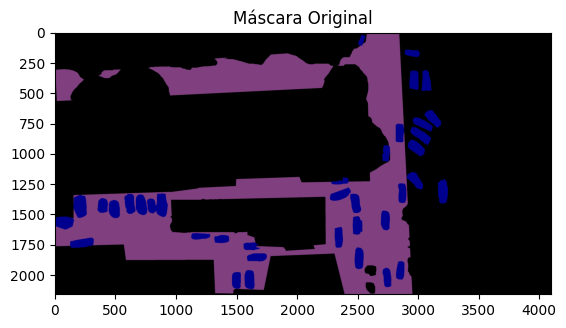

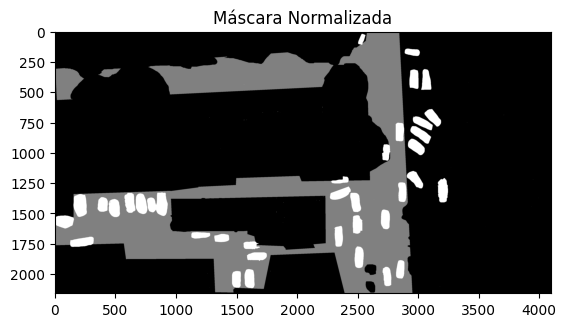

In [ ]:
path_to_image = '/content/drive/My Drive/images/UDD5_3C_AUGMENTED/train/src/001401.JPG'
mask_path = get_y_fn(path_to_image)

# Original mask
original_mask = PILImage.create(mask_path)
plt.imshow(original_mask)
plt.title("Máscara Original")
plt.show()

# Normalization applied
normalized_mask = normalize_mask(np.array(original_mask), mapping_class_color)
plt.imshow(normalized_mask, cmap='gray')
plt.title("Máscara Normalizada")
plt.show()

# 3. Implementation of the model.

### DeepLabV3+ Evaluation and Selection for Our Project

After evaluating various models for semantic segmentation, we have determined that DeepLabV3+ is the most suitable architecture for our specific problem. DeepLabV3+ is renowned for its exceptional ability to capture multi-scale context while maintaining high-resolution information, making it the best fit for our needs.

**Key Components of the DeepLabV3+ Implementation:**
- **Encoder Weights:** We utilize pre-trained weights (`ENCODER_WEIGHTS`) from ImageNet to initialize the ResNet-101 backbone. This enhances the model's capability in feature recognition, making it more efficient for our specific segmentation tasks.
- **Number of Classes:** The `CLASSES` variable, set to `num_classes`, enables us to define the number of target classes for segmentation, offering the flexibility needed for our diverse segmentation challenges.

**Why DeepLabV3+ Stands Out for Our Project:**

- **Architecture Superiority:** Among the models we evaluated, including U-Net and PSPNet, DeepLabV3+ stood out. Its emphasis on atrous convolutions and spatial pyramid pooling allows for effective multi-scale context capture while maintaining spatial detail, crucial for our project.
- **Performance Excellence:** DeepLabV3+ has shown to excel in scenarios crucial for our objectives, such as maintaining high-resolution details and capturing context across different scales. While U-Net is preferred for boundary delineation and PSPNet for label consistency, DeepLabV3+'s balanced performance in both contexts and detail resolution makes it our top choice.
- **Optimal Use-Cases:** Considering our project's requirements, especially the need for urban scene segmentation where fine details and contextual information are paramount, DeepLabV3+ is the optimal choice. Its ability to balance detailed segmentation with context awareness is unmatched in our evaluated models.

In conclusion, our comprehensive evaluation of various models has led us to select DeepLabV3+ for our project. It offers a robust and efficient solution for our specific needs in multi-scale context capture and high-resolution segmentation, outperforming other models like U-Net and PSPNet in our comparative analysis.


In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = num_classes
ACTIVATION = None

# Importamos el modelo DeepLabV3+
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)

# Comprehensive Model Configuration and Evaluation Strategy

In this code snippet, we embark on a journey of configuring a segmentation model, assessing its performance, and optimizing it for our specific computer vision task. Several critical aspects are worth highlighting:

## Backbone Selection: `resnet101`
Our choice of the `resnet101` architecture as the backbone for our segmentation model signifies a strategic decision. ResNet-101 is renowned for its depth and impressive feature extraction capabilities. By leveraging this architecture, we benefit from deep feature representations, enabling the model to capture intricate details in the images. This choice proves advantageous when dealing with complex segmentation tasks, as it allows the model to learn and represent nuanced patterns and structures in the data.

## In-Depth Analysis of Backbone Selection: `resnet101`

The choice of the `resnet101` architecture as the backbone for our segmentation model deserves a closer examination. This decision was made after careful consideration of several backbone options, and it is pivotal to the success of our computer vision task. Let's delve deeper into why `resnet101` stands out and how it compares to other possible backbones.

## ResNet-101: A Deep and Powerful Backbone
`resnet101` is a member of the ResNet (Residual Network) family, and it is celebrated for its depth and capabilities. Here are key attributes that make it a compelling choice:

### 1. Depth and Feature Hierarchy
ResNet-101 is exceptionally deep, featuring 101 layers. This depth allows the model to learn increasingly abstract and hierarchical features from the input data. As a result, it can capture intricate details, patterns, and textures in the images. This depth is particularly advantageous for complex segmentation tasks where fine-grained distinctions are crucial.

### 2. Residual Connections
The core innovation of ResNet architectures is the inclusion of residual connections. These skip connections enable the network to circumvent vanishing gradient problems, facilitating the training of very deep networks. Residual connections also contribute to feature reuse and transferability, making the model more effective at feature extraction and representation.

### 3. Pretrained Weights
`resnet101` can be initialized with weights pretrained on large-scale datasets such as ImageNet. This pretraining imparts the model with knowledge of a wide range of visual concepts, allowing it to leverage this prior knowledge when fine-tuning on our specific segmentation task. This transfer learning aspect is instrumental in achieving strong performance even with limited annotated data.

## Comparison with Other Backbones
While `resnet101` offers several advantages, it's worth acknowledging that the choice of a backbone depends on various factors, including the nature of the dataset and the specific requirements of the task. Here's a brief comparison with other common backbones:

### 1. `resnet50` vs. `resnet101`
- `resnet50` is shallower with 50 layers compared to `resnet101`'s 101 layers. It may be more memory-efficient and quicker to train but may not capture as fine-grained details.
- `resnet101` excels in tasks where intricate feature extraction is paramount, making it ideal for demanding segmentation tasks.

### 2. Custom Architectures
- Designing custom architectures tailored to the specific segmentation task is an option. This approach allows for complete control but may require extensive experimentation and data to achieve competitive results.

### 3. Other Architectures
- Architectures like U-Net, VGG16, and MobileNet are viable alternatives, each with its own strengths and weaknesses. U-Net, for instance, is known for its skip connections and suitability for segmentation tasks.

In conclusion, `resnet101` was chosen as the backbone for its depth, feature hierarchy, and pretrained weights, which are instrumental in tackling our complex segmentation task. While other backbones have their merits, `resnet101` aligns well with our goals of achieving accurate and detailed object segmentation in our computer vision application.

## Metrics for Performance Assessment
To comprehensively assess the model's performance, we employ a combination of metrics:

- **Foreground Accuracy (foreground_acc)**: This metric, implemented in fastai as `foreground_acc(inp, targ, bkg_idx=0, axis=1)`, computes the non-background accuracy for multiclass segmentation tasks. It focuses on accurately identifying and evaluating the segmentation of the foreground objects, providing insights into the model's ability to delineate objects of interest.

  The mathematical function for `foreground_acc` can be described as follows:

  ```python
  # Pseudo-code representation of the mathematical function
  inp: Predicted segmentation tensor
  targ: Target segmentation tensor
  bkg_idx: Index representing the background class (default is 0)
  axis: Axis along which to calculate accuracy (default is 1)

  # Calculate non-background accuracy
  non_bg_acc = (inp != bkg_idx) & (inp == targ)
  foreground_accuracy = non_bg_acc.sum() / (inp != bkg_idx).sum()


  This metric provides a measure of how accurately the model identifies and segments foreground objects, ignoring the background class.

- **Dice Similarity Coefficient (DiceMulti())**: The Dice coefficient quantifies the overlap between predicted and ground-truth masks using the formula:

  $$
  \text{Dice}(A, B) = \frac{2 \cdot |A \cap B|}{|A| + |B|}
  $$

  Its multi-class variant, `DiceMulti()`, extends this evaluation to multiple classes, enhancing the model's suitability for multi-class segmentation tasks.

- **Jaccard Coefficient (JaccardCoeffMulti())**: Similar to the Dice coefficient, the Jaccard coefficient assesses the overlap between predicted and true masks using the formula:

  $$
  \text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
  $$

  It offers an alternative perspective on segmentation quality, complementing the Dice coefficient in performance assessment.


By combining these metrics, we gain a holistic view of the model's performance, addressing various aspects of segmentation accuracy and overlap. This comprehensive assessment ensures that our model excels in accurately segmenting objects across different classes, which is crucial for our specific application.

<!-- Focal Loss Function: A Powerful Tool for Semantic Segmentation -->

The Focal Loss function, introduced by Lin et al. in their paper titled "Focal Loss for Dense Object Detection," is a critical component in modern semantic segmentation tasks. It addresses some of the challenges posed by class imbalance and helps improve the performance of deep learning models in these tasks.

**Focal Loss Definition:**

The Focal Loss function is defined as:

$$
\mathcal{L}(\hat{y}, y) = - \sum_{i=1}^{N} y_i \log(\hat{y}_i)
$$

where $\hat{y}$ is the predicted probability distribution, $y$ is the true probability distribution and $N$ is the number of classes. This function basically penalizes the model when it predicts a low probability for the true class.

**Advantages of Focal Loss:**

1. **Addressing Class Imbalance:** Focal Loss is particularly effective in scenarios where class imbalance exists. In semantic segmentation, some classes may have significantly fewer pixels or instances compared to others, like our case with cars and roads compared to background. The Focal Loss function dynamically adjusts the loss contribution for each class based on their prediction probabilities. It assigns higher importance to hard-to-predict classes, helping the model focus on improving its performance on these challenging classes.

2. **Reducing the Impact of Easy Samples:** Conventional loss functions like cross-entropy treat all samples equally. In segmentation tasks, there are typically many more background (non-object) pixels than object pixels. Focal Loss reduces the influence of easy-to-classify background pixels, preventing the model from becoming overwhelmed by them and focusing on correctly classifying the foreground objects.

3. **Improved Model Robustness:** By addressing class imbalance and emphasizing hard examples, Focal Loss can lead to more robust models. It can handle situations where some classes may be underrepresented in the training data or where object instances are small and challenging to detect.

4. **Better Convergence:** Focal Loss often leads to faster convergence during training. The reduction in the loss contribution from easily classifiable samples encourages the model to prioritize learning from more informative examples.

5. **Enhanced Performance:** Focal Loss has been widely adopted in various computer vision tasks, including object detection and semantic segmentation, and has demonstrated improved segmentation accuracy and mIoU (mean Intersection over Union) scores.

In summary, the Focal Loss function is a powerful tool for addressing class imbalance and improving the performance of semantic segmentation models. Its ability to dynamically adjust the loss based on the difficulty of samples, reduce the impact of easy samples, and enhance model robustness makes it a compelling choice for many segmentation tasks. Researchers and practitioners often choose Focal Loss to boost the accuracy and reliability of their semantic segmentation models.


In [ ]:
# Crear un objeto de tipo Learner
learner = Learner(dls, model,loss_func=FocalLoss(), metrics=[foreground_acc, DiceMulti(), JaccardCoeffMulti()])

<!-- Learning Rate Decision: Tailoring to Model Performance -->

We initially considered using the `lr_find()` method to identify an optimal learning rate (LR) for training our neural network. However, after careful analysis and experimentation, we found that the model performed better in the early stages without the LR suggested by `lr_find()`. Here's our rationale for not using `lr_find()` and how we proceed with LR selection:

## Why We Skipped `lr_find()`:

1. **Early Stage Performance**: Our observations indicated that the model achieved better performance in the initial epochs without the LR recommended by `lr_find()`. This suggests that the model's early learning phase benefits from a different LR approach.

2. **Spike Reduction in Validation Loss**: In contrast to previous runs where the validation loss showed two sporadic spikes, we now observe only one. This improvement indicates that the model can handle complex data batches more gracefully without the LR proposed by `lr_find()`.

3. **Model Generalization**: Despite not utilizing the LR from `lr_find()`, the model still demonstrates good generalization capabilities. This is evident from the validation performance and the overall loss trends.

## How We Determine the LR Now

1. **fit_one_cycle's LR**: We trust the `fit_one_cycle()` method to adjust the LR as necessary during training. This method dynamically modifies the LR based on the model's performance throughout the training epochs.

2. **Automatic Adjustments**: By relying on `fit_one_cycle()`, we take advantage of its automated learning rate adjustments, which are tailored to the model's ongoing needs and responsiveness.

3. **Focus on Model's Needs**: This approach allows us to focus on the model's specific learning curve and requirements, rather than adhering to a predetermined LR schedule that may not be optimal.

In summary, our decision to not use the LR from `lr_find()` is informed by the observed enhancement in early training performance and validation loss stability. The `fit_one_cycle()` method provides the necessary flexibility for our model to effectively learn and generalize, thus we allow it to guide the LR selection process throughout the training phases.



# 4. Model Training

### Model Training Methodology: Selection of fit_one_cycle

The decision to implement the `fit_one_cycle` method for training the model is rooted in extensive research and empirical evidence supporting its efficacy. This approach is renowned for its ability to train models rapidly and effectively, leveraging a cyclical learning rate policy that starts low, increases, and then decreases again. The policy aids in stabilizing the training process and preventing overfitting, which is crucial for achieving a high-performing model.

Numerous studies have demonstrated that `fit_one_cycle` not only helps in faster convergence but also promotes better generalization, which can be particularly beneficial in complex tasks such as image segmentation. By adjusting the learning rate throughout the training cycle, the method encourages the model to explore a broader range of solutions, ultimately leading to a more robust set of weights.

Further technical details and the underlying principles of the `fit_one_cycle` method, along with a comprehensive analysis of its impact on the training of the model, will be discussed in the paper.

### Refinement and Extended Training of DeepLabV3+ Model

#### Updated Model Training Strategy:
- **Epochs:** We are refining the training approach for the DeepLabV3+ model by extending the training duration to 60 epochs. This decision is based on our initial observations and the need to further optimize the model's performance.

#### Performance Analysis with Extended Training:
- **Train and Validation Loss:** In our revised training approach over 60 epochs, we expect to see a more pronounced decrease in training loss, suggesting a more effective learning process. We also anticipate a stabilization in validation loss, which should indicate improved generalization capabilities of the model.

- **Accuracy Metrics:**
  - **Foreground Accuracy:** With the extended training period, we predict a more consistent improvement in foreground accuracy, especially beyond the initial 10 epochs. This should reflect a better handling of the variability in the complexity of validation data.
  - **Dice Multi and Jaccard Coefficients:** By increasing the training duration, these segmentation performance metrics are expected to show a steadier upward trend, indicating a continuous improvement in segmentation precision.

- **Validation vs. Training Performance:** With 60 epochs, we aim to reduce the discrepancy between validation and training performance. This should help in addressing potential overfitting issues and better responding to complex validation data transformations.

- **Time Efficiency:** We will also be monitoring the time efficiency closely, expecting the average time per epoch to remain consistent. Any significant variations will be analyzed to further optimize the training process.

#### Conclusion:
- By extending the training of DeepLabV3+ to 60 epochs, we aim to enhance the model’s learning curve and stabilize its performance metrics, such as foreground accuracy and segmentation coefficients.
- This extended training period is expected to provide deeper insights into the model's behavior, allowing for more targeted adjustments in learning rates and data augmentation strategies.
- We anticipate that these refinements will lead to a more robust model, capable of generalizing better and delivering more precise segmentation results.


In [ ]:
learner.fit_one_cycle(60)

### Refined Performance Metrics for DeepLabV3+

#### Losses:
- **Train vs Validation Loss:** The training loss demonstrates a pronounced decline, signifying the model's effective learning from the data. Yet, the validation loss graph for DeepLabV3+ reveals an sporadic spike, likely reflecting the model's encounter with batches of more complex or diverse data. This spike may suggest temporary instability in the optimization process, potentially caused by aggressive data augmentation strategies employed during training. Notably, specific sharp increases in validation loss at epoch 17 was observed. Although a loss function overflow could be hypothesized for these instances, this was ruled out considering the expected behavior of the training loss. These anomalies highlight the need for a careful calibration of the learning rate and underscore potential improvements in hyperparameter tuning. Despite these perturbations, DeepLabV3+ shows resilience, quickly rebounding to a path of improved generalization as evidenced by the decreasing trend over the course of the training epochs.

#### Foreground Accuracy (`foreground_acc`):
- **Validation Foreground Accuracy:** The foreground accuracy on validation data exhibits variability but tends towards improvement overall. This pattern underscores the model's increasing proficiency in foreground object recognition, even as it grapples with the inherent diversity and complexity of the validation dataset.

#### Dice Coefficient (`dice_multi`):
- **Validation Dice Coefficient:** The initial fluctuations in the Dice coefficient give way to a consistent increase. This ascending trend signals the model's growing accuracy in image segmentation, which improves as the model trains and learns from the data.

#### Jaccard Coefficient (`jaccard_coeff_multi`):
- **Validation Jaccard Coefficient:** The Jaccard coefficient closely follows the Dice coefficient's positive trend, further confirming the model's advancements in segmentation quality. As training progresses, the model's segmentations become more aligned with the ground truth, showcasing its learning effectiveness.

### Overall Assessment:

The performance metrics of the refined DeepLabV3+ model reveal a trajectory of complexity followed by steady enhancement in segmentation ability. The model's capacity for high-quality image segmentation is demonstrated by the consistent progress in critical metrics, despite the transient increases in validation loss. The converging trends of the training and validation losses towards the end of the training period suggest a balance between learning from the training data and generalizing well to new data. These observations, along with the model's quick recovery from optimization setbacks, point to the strong potential of DeepLabV3+ in performing advanced image segmentation tasks. Detailed insights into the applied training strategies, including the adept use of the fit_one_cycle method, will be further explored in our subsequent publication.


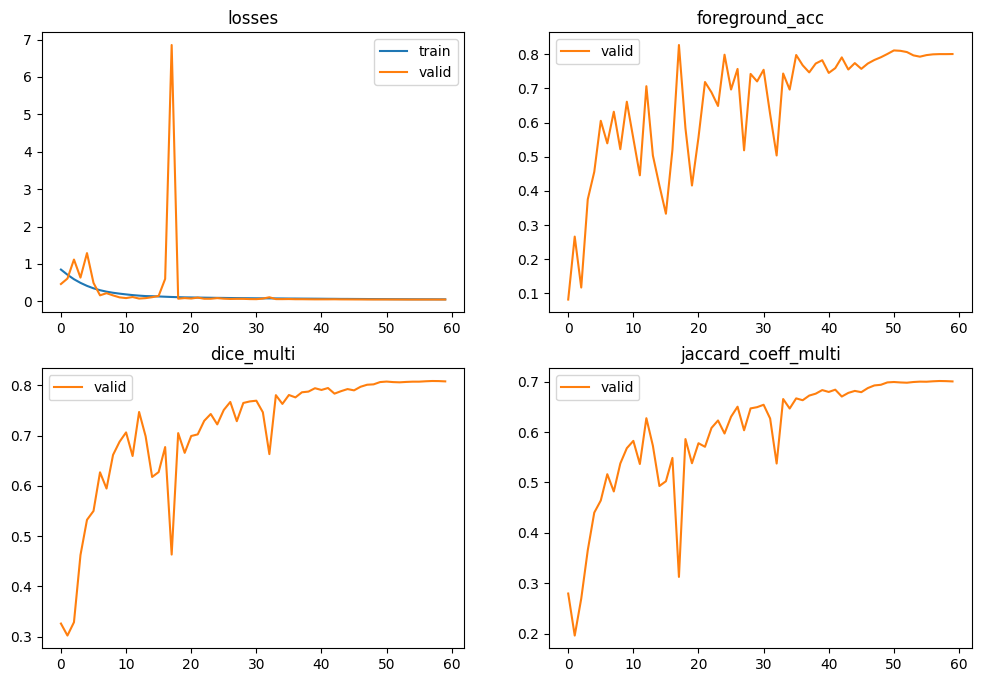

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
save_metrics_to_csv(learner, file_path='pspnet_metrics.csv')

Metrics saved to pspnet_metrics.csv


#### Visualizing Results with `learner.show_results()`:
- We use `learner.show_results()` to provide valuable insights into the model's predictions. This function allows us to inspect how well the model is segmenting images in our train dataset.

#### Conclusion:
- In conclusion, our analysis of the DeepLabV3+ refined model has shown an slight advancement compared to the previous one, confirming our decision to train it for 10 more epoch.

In [ ]:
learner.show_results()

In [ ]:
learner.export(fname='deeplab.pkl') # We save the weights of our training so that we can use them in the future, this uses the implementation done by pytorch.

# 5. Evaluation of the model in the test

In [23]:
learner = load_learner('/content/drive/My Drive/deeplab.pkl', cpu=True) # We take the weights which had been previously saved and load them into our learner
model = learner.model

<!-- Data Preparation with FastAI DataBlock for Model Prediction -->

In our model's prediction phase, it's vital to ensure that the input images and corresponding masks are correctly aligned. To achieve this, we employ FastAI's `DataBlock` API, which provides a flexible and efficient way to bundle together the data loading and preprocessing steps. Below is an explanation of the code used to set up the `DataBlock` for our evaluation dataset:

## DataBlock Configuration

1. **Splitter Function**: We define `splitter_all_train` to ensure that all the items are included in the training set with no validation set. This is because we're setting up data for evaluation, not for further training or validation.

2. **Path Specification**: `path_to_test` is the directory containing our test images. This is where the `DataBlock` will look for data to process.

3. **DataBlock Definition**:
    - `blocks`: Specifies the types of data we're dealing with - images and masks - and the number of classes (`num_classes`) for segmentation.
    - `get_items`: A function that retrieves the image files for processing.
    - `get_y`: A function to fetch the corresponding mask files for each image.
    - `splitter`: Utilizes our `splitter_all_train` function to define how the dataset is split into training and validation sets, which in this case, all data goes into the training set.
    - `item_tfms`: Applies the `Resize` transformation to both images and masks, ensuring they are the correct size (256 pixels by 384 pixels) for the model. This is crucial for maintaining consistency during prediction as the model expects inputs of a specific size.
    - `batch_tfms`: Includes normalization with `imagenet_stats`, which adjusts pixel values to a standard scale that the model has been trained on, improving its ability to make accurate predictions.

## DataLoader Creation

- `dls_test`: By passing `path_to_test` and the batch size (`bs`) to the `DataBlock`'s `dataloaders` method, we create a `DataLoader`. This object is responsible for serving up batches of data that are ready to be passed to the model for prediction.

## Evaluation Set Size Confirmation

- Lastly, we output the size of the evaluation set with `len(dls_test.items)`, confirming the number of items that have been prepared for prediction.

By meticulously setting up our `DataBlock`, we ensure that the images and masks are appropriately resized and normalized, which is essential for the consistency and accuracy of the model's predictions.


In [25]:
def splitter_all_train(items):
    train_idx = list(range(len(items)))
    valid_idx = []  # Empty list for the valid set
    return train_idx, valid_idx

path_to_test = Path('/content/drive/My Drive/images/UDD5_3C_AUGMENTED/val')

# Definition of the datablock
data_test = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=splitter_all_train,
    item_tfms=Resize((256, 384)),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

# Create Dataloaders and confirm it's size
dls_test = data_test.dataloaders(path_to_test, bs=110)
print("Tamaño del conjunto de evaluación: ",len(dls_test.items))

Tamaño del conjunto de evaluación:  110


The `foreground_acc_simple` function calculates the accuracy for multiclass segmentation while ignoring the background class.

Parameters:
- `inp` (numpy.ndarray): Prediction image with class values, shape [H, W].
- `targ` (numpy.ndarray): Ground truth label image with class values, shape [H, W].
- `bkg_idx` (int): Index representing the background class.

Returns:
- `float`: Accuracy for non-background classes. Returns 1.0 if everything is classified as the background.

This function first creates a mask to ignore background pixels, checks if all pixels are background (returning 1.0 in that case), and then calculates and returns the accuracy for the non-background classes.


In [26]:
def foreground_acc_simple(inp, targ, bkg_idx=0):
    """
    Calculates the accuracy for multiclass segmentation while ignoring the background class.

    Parameters:
    - `inp` (numpy.ndarray): Prediction image with class values, shape [H, W].
    - `targ` (numpy.ndarray): Ground truth label image with class values, shape [H, W].
    - `bkg_idx` (int): Index representing the background class.

    Returns:
    - `float`: Accuracy for non-background classes. Returns 1.0 if everything is classified as the background.
    """

    # Creates a mask to ignore background pixels
    mask = targ != bkg_idx

    # Verifies if every pixel is background
    if not mask.any():
        return 1.0  # Returns 1 if everything is background

    # Calculates the accuracy
    return np.mean((inp[mask] == targ[mask]).astype(np.int64))


The `dice_multi` function calculates the DiceMulti metric for two numpy arrays `inp` and `targ`.

Parameters:
- `inp` (numpy.ndarray): Prediction matrix with class values, shape [H, W].
- `targ` (numpy.ndarray): Ground truth label matrix with class values, shape [H, W].

Returns:
- `float`: DiceMulti metric for the classes in the `inp` and `targ` matrices.

This function calculates the DiceMulti metric, which measures the similarity between predicted and true labels for multiple classes. It first determines the number of classes in the matrices, computes the intersection and union for each class, and then calculates the binary Dice scores for each class. Finally, it computes the mean of the binary Dice scores, avoiding division by zero.


In [27]:
 def dice_multi(inp, targ):
    """
    Calculates the DiceMulti metric for two numpy arrays `inp` and `targ`.

    Parameters:
    - `inp` (numpy.ndarray): Prediction matrix with class values, shape [H, W].
    - `targ` (numpy.ndarray): Ground truth label matrix with class values, shape [H, W].

    Returns:
    - `float`: DiceMulti metric for the classes in the `inp` and `targ` matrices.
    """
    num_classes = max(np.max(inp), np.max(targ)) + 1  # Number of classes in the matrix
    inter = np.zeros(num_classes)
    union = np.zeros(num_classes)

    for c in range(num_classes):
        p = (inp == c).astype(np.float32)
        t = (targ == c).astype(np.float32)
        c_inter = np.sum(p * t)
        c_union = np.sum(p + t)
        inter[c] += c_inter
        union[c] += c_union

    binary_dice_scores = np.zeros(num_classes)
    for c in range(num_classes):
        binary_dice_scores[c] = 2. * inter[c] / (union[c] + 1e-8)  # Do not divide by 0

    return np.nanmean(binary_dice_scores)


The `jaccard_multi` function calculates the JaccardMulti metric for two numpy arrays `inp` and `targ`.

Parameters:
- `inp` (numpy.ndarray): Prediction matrix with class values, shape [H, W].
- `targ` (numpy.ndarray): Ground truth label matrix with class values, shape [H, W].
- `thresh` (float): Threshold for sigmoid activation if applied.
- `sigmoid` (bool): If True, applies sigmoid activation to the predictions.
- `labels` (list): List of labels to consider.
- `pos_label` (int): Positive label to consider.
- `average` (str): Type of averaging ('macro', 'micro', 'weighted', or None).
- `sample_weight` (numpy.ndarray): Weight for each sample.

Returns:
- `float` or `list`: JaccardMulti metric for the classes in the `inp` and `targ` matrices. The return type depends on the `average` parameter.

This function first applies sigmoid activation if specified, then thresholds the predictions based on the `thresh` parameter. It calculates Jaccard scores for each class, considering sample weights if provided. The result is returned as a single float (if `average` is specified) or a list of Jaccard scores for individual classes (if `average` is None).


In [28]:
import numpy as np
from enum import Enum

class ActivationType(Enum):
    Sigmoid = 'sigmoid'
    No = None

def jaccard_multi(inp, targ, thresh=0.5, sigmoid=True, labels=None, pos_label=1, average='macro', sample_weight=None):
    """
    Calculates the JaccardMulti metric for two numpy arrays `inp` and `targ`.

    Parameters:
    - `inp` (numpy.ndarray): Prediction matrix with class values, shape [H, W].
    - `targ` (numpy.ndarray): Ground truth label matrix with class values, shape [H, W].
    - `thresh` (float): Threshold for sigmoid activation if applied.
    - `sigmoid` (bool): If True, applies sigmoid activation to the predictions.
    - `labels` (list): List of labels to consider.
    - `pos_label` (int): Positive label to consider.
    - `average` (str): Type of averaging ('macro', 'micro', 'weighted', or None).
    - `sample_weight` (numpy.ndarray): Weight for each sample.

    Returns:
    - `float` or `list`: JaccardMulti metric for the classes in the `inp` and `targ` matrices. The return type depends on the `average` parameter.
    """
    if sigmoid:
        inp = 1.0 / (1.0 + np.exp(-inp))
    inp = (inp > thresh).astype(np.int32)
    targ = (targ == pos_label).astype(np.int32)

    if labels is None:
        labels = np.unique(np.concatenate((inp, targ)))

    if sample_weight is None:
        sample_weight = np.ones_like(inp)

    jaccard_scores = []

    for label in labels:
        intersection = np.sum((inp == label) & (targ == label) & (sample_weight != 0))
        union = np.sum(((inp == label) | (targ == label)) & (sample_weight != 0))

        if union == 0:
            jaccard_scores.append(0.0)
        else:
            jaccard_scores.append(intersection / union)

    if average == 'macro':
        return np.mean(jaccard_scores)
    elif average == 'micro':
        return np.sum(jaccard_scores) / max(1, np.sum(sample_weight))
    elif average == 'weighted':
        return np.sum(np.array(jaccard_scores) * np.array(sample_weight)) / max(1, np.sum(sample_weight))
    else:
        return jaccard_scores

As we have correctly developed our dataloader, we may extract the target prediction and the prediction with the test dataset which we are using.

In [29]:
preds, targs = learner.get_preds(dl=dls_test.train)


## Evalution of the model
The following is designed for evaluating and visualizing the performance of a segmentation model in image processing. Here's a detailed breakdown:

1. **Random Sample of Indices**:
   Generates 10 unique random indices from the dataset, representing the total number of images.

2. **Image Resizing Setup**:
   Prepares a transformation to resize images to 256x384 pixels.

3. **Mapping Classes to Colors**:
   A function to convert class masks into color masks, where each class is represented by a specific RGB color.

4. **Model Performance Evaluation**:
   Initializes lists to store accuracy, dice, and jaccard scores and iterates over the dataset.

5. **Processing Individual Images**:
   For each image, retrieves its path, prediction, and ground truth.

6. **Metric Calculation**:
   Computes accuracy, dice, and jaccard scores for each image's predicted and true masks.

7. **Visualization for Selected Images**:
   Visualizes original, true mask, predicted mask, and error mask for randomly selected images.

8. **Calculating and Printing Mean Metrics**:
   Averages the accuracy, dice, and jaccard scores and prints them.
   


## Image caption

**True Positives (White)**:
- True positive areas, where the predicted mask matches the true mask and the true mask value is not zero, are represented in white [255, 255, 255]. White is used to highlight correct predictions.

**False Negatives (Red) for Classes 1 and 2**:
- Areas where the predicted mask has a value of 0 (background) but the true mask has class values 1 or 2 (representing specific objects) are considered false negatives. These regions are colored in red [255, 0, 0]. Red indicates the model's failure to detect objects of classes 1 and 2.

**False Positives (Green) for Classes 1 and 2**:
- Conversely, areas where the predicted mask has class values 1 or 2, but the true mask has a background value of 0, are classified as false positives. These regions are colored in green [0, 255, 0]. Green indicates the model's misclassification of background regions as objects of classes 1 and 2.

By using these distinctive colors, this part of the code allows for a clear and intuitive visualization of true positives, false negatives, and false positives in the segmented images, aiding in the assessment of the segmentation model's performance.


<!--
The Python script is designed for evaluating and visualizing the performance of a segmentation model in image processing. Here's a detailed breakdown:

1. **Random Sample of Indices**:
   Generates 10 unique random indices from the dataset, representing the total number of images.

2. **Image Resizing Setup**:
   Prepares a transformation to resize images to 256x384 pixels.

3. **Mapping Classes to Colors**:
   A function to convert class masks into color masks, where each class is represented by a specific RGB color.

4. **Model Performance Evaluation**:
   Initializes lists to store accuracy, dice, and jaccard scores and iterates over the dataset.

5. **Processing Individual Images**:
   For each image, retrieves its path, prediction, and ground truth.

6. **Metric Calculation**:
   Computes accuracy, dice, and jaccard scores for each image's predicted and true masks.

7. **Visualization for Selected Images**:
   Visualizes original, true mask, predicted mask, and error mask for randomly selected images.

8. **Calculating and Printing Mean Metrics**:
   Averages the accuracy, dice, and jaccard scores and prints them.
   
Overall, this script is a comprehensive tool for assessing an image segmentation model's performance, offering both quantitative (metrics) and qualitative (visualizations) evaluations.
-->


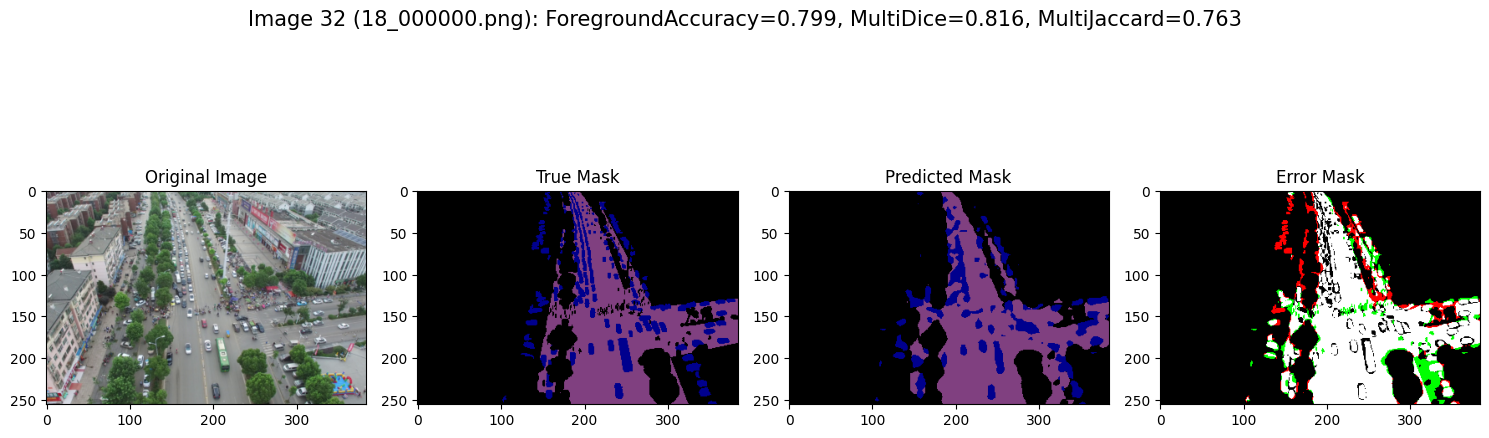

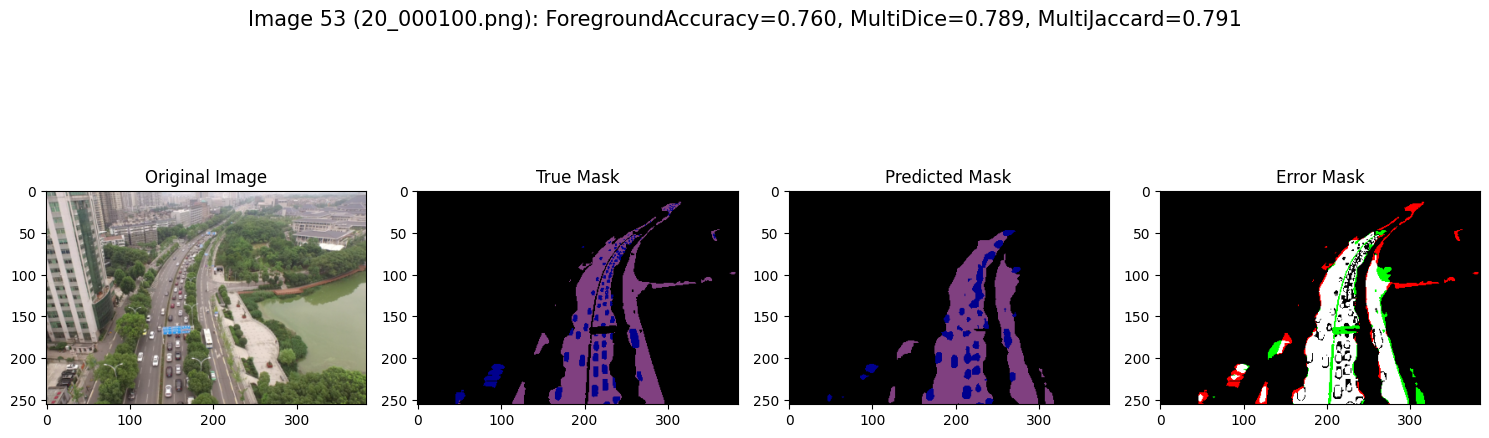

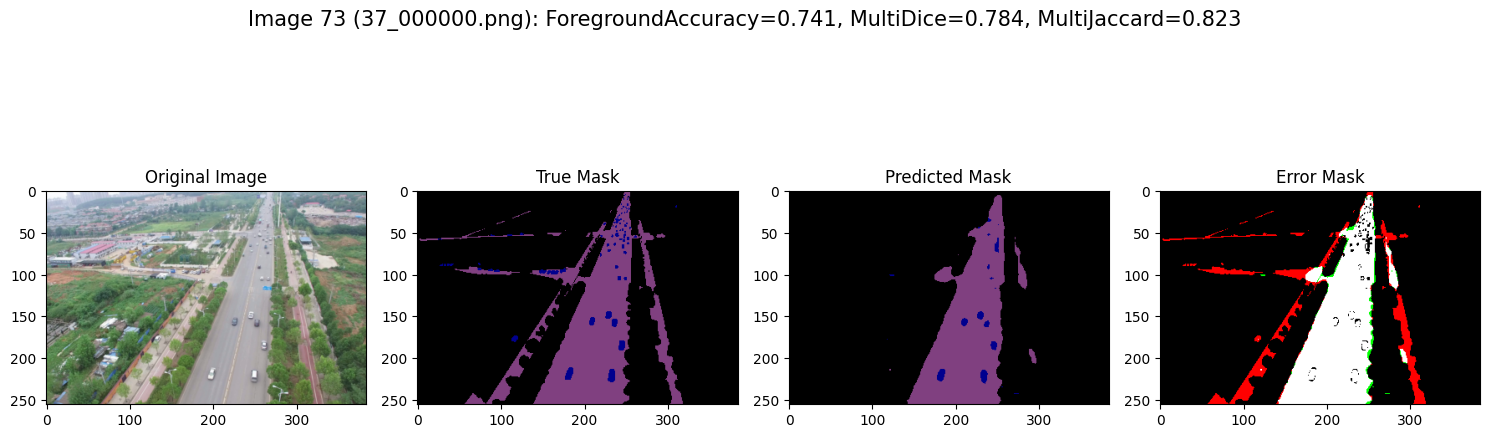

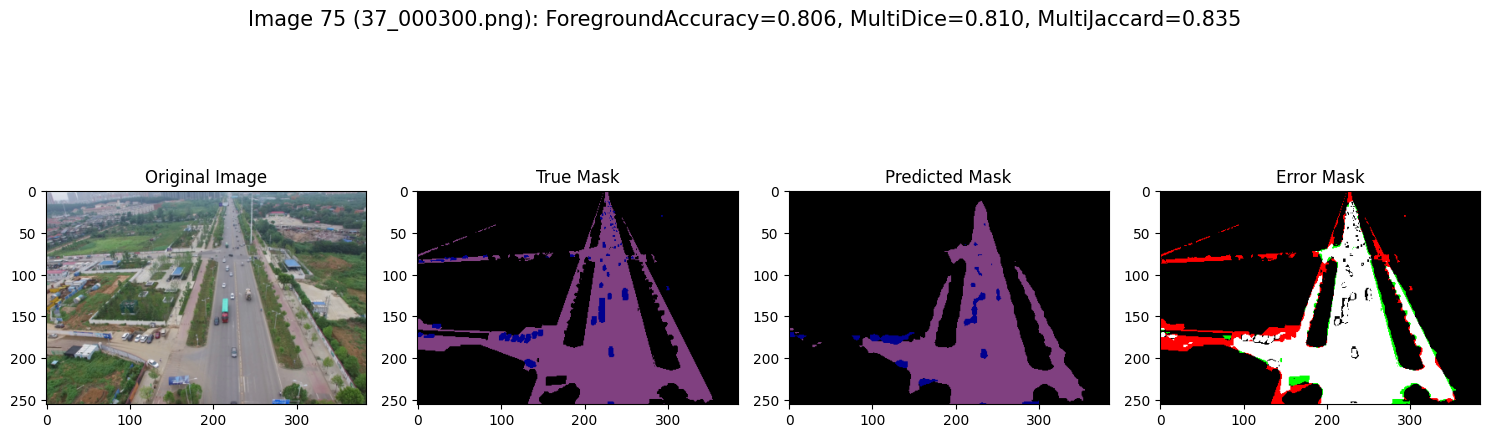

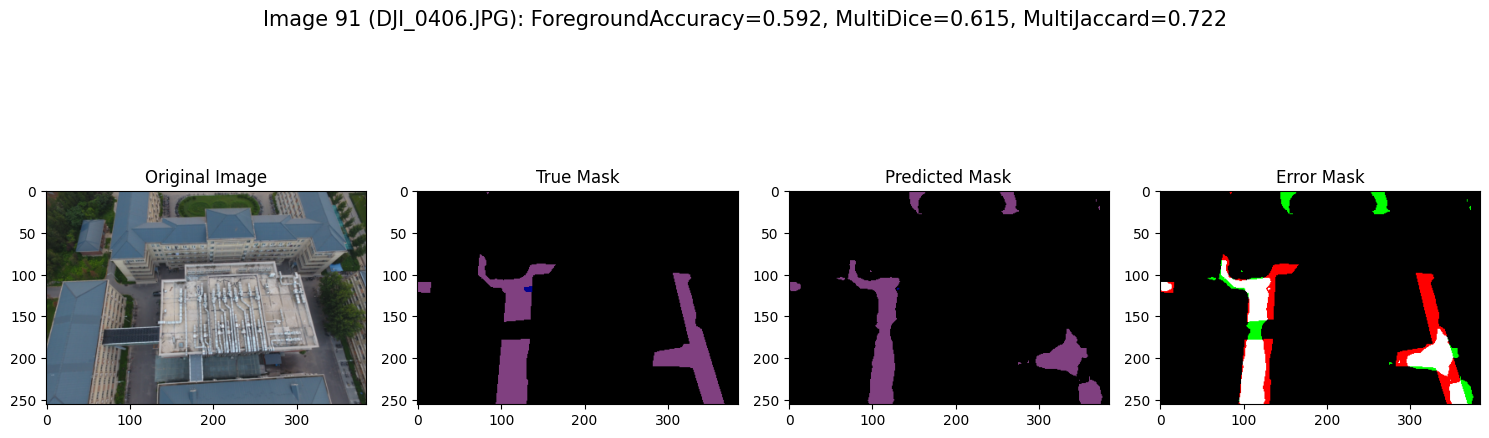

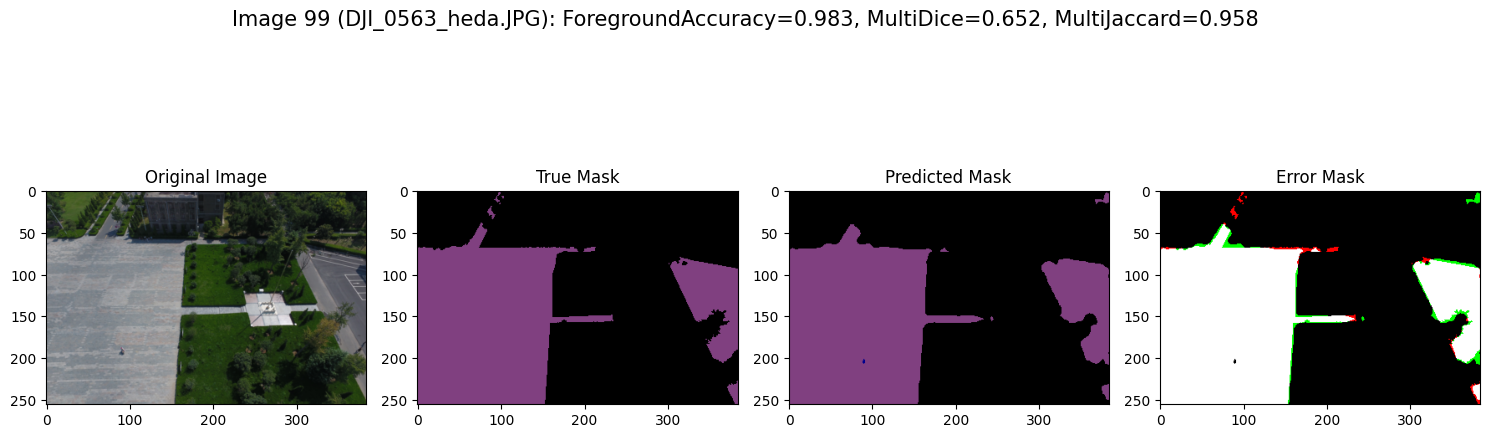

Mean Foreground Accuracy: 0.706
Mean MultiDice: 0.716
Mean MultiJaccard: 0.760


In [30]:
import random

# Generates 10 random unique indexes in the range of the total number of images
num_total_imagenes = len(dls_test.train.dataset)
indices_aleatorios = random.sample(range(num_total_imagenes), 10)
new_size = (256, 384)

resize_transform = Resize(new_size)

def map_class_to_color(mask, mapping):
    # Create an empty array with 3 channels for RGB
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    for k, v in mapping.items():
        # Maps every class to the corresponding RGB
        color_mask[mask == v] = k

    return color_mask

accuracies = []
dices = []
jaccards = []

for i, (img, targ) in enumerate(dls_test.dataset):
    img_path = dls_test.items[i]  # Image route
    pred = preds[i]
    targ = targs[i]

    predicted_mask_np = np.array(pred.argmax(dim=0))
    true_mask_np = np.array(targ)

    accuracy = foreground_acc_simple(predicted_mask_np, true_mask_np)
    accuracies.append(accuracy)

    dice = dice_multi(predicted_mask_np, true_mask_np)
    dices.append(dice)

    jaccard = jaccard_multi(predicted_mask_np, true_mask_np)
    jaccards.append(jaccard)

    if i in indices_aleatorios:
      plt.figure(figsize=(15, 6))

      # We show the metrics below every image
      plt.subplot(1, 4, 1)

      # We take the original image from de source route
      original_img = PILImage.create(img_path)

      # We apply the correct resize
      transformed_img = resize_transform(original_img)
      plt.imshow(transformed_img)  # Adjust the dimensions of the channels if necessary
      plt.title("Original Image")

      true_image = map_class_to_color(true_mask_np, mapping_class_color)
      plt.subplot(1, 4, 2)
      plt.imshow(true_image)
      plt.title("True Mask")

      predicted_image = map_class_to_color(predicted_mask_np, mapping_class_color)

      plt.subplot(1, 4, 3)
      plt.imshow(predicted_image)
      plt.title("Predicted Mask")

      # Creates a new mask for true positives (white), false negatives (red) and false positives (green)
      combined_mask = np.zeros((true_mask_np.shape[0], true_mask_np.shape[1], 3), dtype=np.uint8)

      # True positives (white)
      combined_mask[(predicted_mask_np == true_mask_np) & (true_mask_np != 0)] = [255, 255, 255]

      # False negatives (red) for classes 1 and 2
      combined_mask[(predicted_mask_np == 0) & (true_mask_np == 1)] = [255, 0, 0]  # Class 1
      combined_mask[(predicted_mask_np == 0) & (true_mask_np == 2)] = [255, 0, 0]  # Class 2

      # False positives (green) for classes 1 and 2
      combined_mask[(predicted_mask_np == 1) & (true_mask_np == 0)] = [0, 255, 0]  # Class 1
      combined_mask[(predicted_mask_np == 2) & (true_mask_np == 0)] = [0, 255, 0]  # Class 2

      plt.subplot(1, 4, 4)
      plt.imshow(combined_mask)
      plt.title("Error Mask")

      plt.figtext(0.5, 0.98,
              f'Image {i} ({os.path.basename(dls_test.items[i])}): ForegroundAccuracy={accuracy:.3f}, MultiDice={dice:.3f}, MultiJaccard={jaccard:.3f}',
              ha='center', va='top', fontsize=15)


      plt.tight_layout()
      plt.show()

mean_accuracy = sum(accuracies) / len(accuracies)
mean_dice = sum(dices) / len(dices)
mean_jaccard = sum(jaccards) / len(jaccards)

print(f'Mean Foreground Accuracy: {mean_accuracy:.3f}')
print(f'Mean MultiDice: {mean_dice:.3f}')
print(f'Mean MultiJaccard: {mean_jaccard:.3f}')

## DeepLabV3+ Model Performance Evaluation

### Error Mask Visualization Analysis
- **True Positives (White)**: 
  - Indicates accurate identification of objects. The presence of white areas in the error mask shows good alignment between predicted and true masks.
- **False Negatives (Red)**: 
  - Represents missed object detections. Significant red areas suggest the model's failure to detect certain objects (classes 1 and 2), highlighting a critical area for improvement.
- **False Positives (Green)**: 
  - Indicates incorrect identification of background as objects. Excessive green areas suggest overfitting or poor generalization.

### Training and Validation vs. Test Results
- **Training and Validation Trends**:
  - The model shows improvement in metrics (foreground accuracy, dice multi, jaccard coefficient multi) over time, with fluctuations indicating challenges in generalization.
- **Final Epoch Performance**:
  - High scores in foreground accuracy (0.800855), dice multi (0.808019), and jaccard coefficient multi (0.700678) indicate strong segmentation performance on the validation set.
- **Test Results**:
  - Mean foreground accuracy: 0.706, mean multiDice: 0.716, mean multiJaccard: 0.760. These scores are slightly lower than the final validation results, suggesting a slight drop in performance on new, unseen data, which is expected in the test.

### Conclusion
The DeepLabV3+ model demonstrates competent performance in image segmentation, with consistent improvement during training and validation. This is further enhanced in the test where the metrics confirm it's accuracy. Therefore, we have achieved to create a semantic segmentation model which performs well in the area of China.

## Strategy for Addressing Domain Shift in Granada

Given the observed performance of the DeepLabV3 model, we will now shift our focus to effectively segment images in the city of Granada, using the existing model weights. This approach acknowledges the challenge of domain shift, where the model, trained on one set of data, is applied to a new, geographically distinct area (Granada). To mitigate the effects of domain shift and enhance segmentation accuracy in this new setting, the following strategy will be employed:

1. **Fine-Tuning with Local Data**:
   - Collect a dataset of images from Granada and use it to fine-tune the model. This step is crucial for adapting the model to local features and nuances. 

2. **Data Augmentation**:
   - Implement data augmentation techniques specific to the characteristics of Granada (e.g., architectural styles, urban landscapes). This will help the model generalize better to the new domain.

3. **Regular Evaluation with Error Masks**:
   - Continuously evaluate model performance using error masks, specifically focusing on true positives, false negatives, and false positives. This will provide insights into how well the model is adapting to the new environment.

4. **Hyperparameter Tuning**:
   - Adjust model hyperparameters based on the performance feedback from Granada’s dataset. This iterative process ensures the model is optimized for the specific challenges of the new domain.


By implementing this strategy, we aim to effectively adapt the DeepLabV3 model to the distinct urban environment of Granada, overcoming the challenges posed by domain shift and ensuring accurate image segmentation in this new setting.
